# About

See what BERT is all about. This version is meant to run on our server.

replication of the following blog post:

### News Topic Similarity Measure using Pretrained BERT Model

https://medium.com/the-artificial-impostor/news-topic-similarity-measure-using-pretrained-bert-model-1dbfe6a66f1d

https://github.com/ceshine/pytorch-pretrained-BERT/blob/master/notebooks/Next%20Sentence%20Prediction.ipynb

https://anaconda.org/conda-forge/pytorch-pretrained-bert

### various implementations of BERT

https://pypi.org/project/pytorch-pretrained-bert/

https://github.com/huggingface/transformers

https://github.com/tensorflow/models/tree/master/official/nlp/bert

https://github.com/google-research/bert

https://anaconda.org/akode/bert-tensorflow

using the hugging face one, is most popular in conda downloads, and is the one used by the blog author

https://github.com/huggingface/pytorch-pretrained-BERT

https://anaconda.org/conda-forge/pytorch-pretrained-bert


### Understanding searches better than ever before

google's white paper

https://www.blog.google/products/search/search-language-understanding-bert

### bert_en_uncased_L-12_H-768_A-12

BERT on tensorflow hub

https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1

# News Topic Similarity Measure using Pretrained BERT Model

replication

Add a GPU, to the server

https://www.infoworld.com/article/3299703/what-is-cuda-parallel-programming-for-gpus.html

https://cloud.google.com/compute/docs/gpus/

https://cloud.google.com/compute/docs/gpus/add-gpus

https://cloud.google.com/products/calculator/

Then install the CUDA toolkit

https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html

https://developer.nvidia.com/cuda-downloads?target_os=Linux&target_arch=x86_64&target_distro=Ubuntu&target_version=1804&target_type=deblocal![image.png](attachment:image.png)

In [1]:
# checks if GPU is available
import torch
torch.cuda.is_available()

True

# loads our wrapper classes

we're not using NYTimes article feed
instead of the News Title vs News Body, we have Question Title vs Question Body

and we're going to make it similar to Grace's framework, so it will be easier for Chi to adapt

In [3]:
class Suggester_BertTopicSimiliarty():
    def __init__(
        self
        , question_file
        , answer_file
        , sample_n
        , random_state
        , bert_cache
        , logger
        , device
        , max_seq_length
        , batch_size
    ):
        # initializes some vars
        self.question_file = question_file
        self.answer_file = answer_file
        self.sample_n = sample_n
        self.random_state = random_state
        self.bert_cache = bert_cache
        self.logger = logger
        self.device = device
        self.max_seq_length = max_seq_length
        self.batch_size = batch_size
        
        # gets the pre-trained tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(
            "bert-base-uncased"
            , do_lower_case = True
            , cache_dir = self.bert_cache
        )
        
        # gets the pre-trained model
        self.model = BertForNextSentencePrediction.from_pretrained(
            "bert-base-uncased"
            , cache_dir = self.bert_cache
        ).to(self.device)
        
        # instantiates the helper class
        self.ceshiner = Ceshiner()
    
    
    def _construct_corpus(self, questions, answers):
        '''
        helper function that constructs corpus
        with question id, title, accepted answer id, answer body
        note, implicitly only questions with accepted answers will end up in corpus
        '''
        t1 = questions[[
            "id"
            , "title"
            , "tags"
            , "accepted_answer_id"
        ]].rename(columns = {
            "id" : "q_id"
            , "title" : "q_title"
        })

        t2 = answers[[
            "id"
            , "body"
            , "images_list"
            , "code_snippets"
            , "cleaned_body"
        ]].rename(columns = {
            "id" : "a_id"
            , "body" : "a_body"
            , "images_list" : "a_images_list"
            , "code_snippets" : "a_code_snippets"
            , "cleaned_body" : "a_cleaned_body"
        })

        t3 = t1.merge(
            t2
            , left_on = "accepted_answer_id"
            , right_on = "a_id"
            , how = "inner"
        ).drop(columns = "a_id")
        
        # ... removes any cleaned answers that are null
        t4 = t3[t3.a_cleaned_body.notnull()]

        if self.sample_n is not None:
            t5 = t4.sample(self.sample_n, random_state = self.random_state)
        else:
            t5 = t4

        return(t5)
    
    
    def prepare(self):
        '''
        loads data & makes corpus
        '''
#         self.questions = pd.read_csv(self.question_file, delimiter = "\t", encoding = "utf-8")
        self.questions = pd.read_csv(self.question_file, delimiter = ",", encoding = "utf-8")
        self.answers = pd.read_csv(self.answer_file, delimiter = "\t", encoding = "utf-8")
        self.corpus = self._construct_corpus(self.questions, self.answers)
        print(self.corpus.shape)
    
    def get_similar_documents(self, query, num_results = 5, threshold = 0.10):
        sentence_pairs = self.ceshiner.convert_sentence_pair(
            [query] * self.corpus.shape[0]
            , self.corpus.a_cleaned_body.tolist()
            , max_seq_length = self.max_seq_length
            , tokenizer = self.tokenizer
        )
        similarity_scores = self.ceshiner.eval_pairs(
            sentence_pairs = sentence_pairs
            , batch_size = self.batch_size
            , model = self.model
        )
        self.corpus_res = self.corpus.copy()
        self.corpus_res["similarity"] = similarity_scores
        self.best_matches = self.corpus_res.copy()
        self.best_matches = self.best_matches[self.best_matches['similarity'] >= threshold]
        self.best_matches = self.best_matches.sort_values('similarity', ascending = False)
        self.best_matches = self.best_matches[:num_results]
        similar_que = self.best_matches["q_title"]
        similar_ans = self.best_matches["a_cleaned_body"]
        return(similar_que, similar_ans)


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target
        
        
class Ceshiner():
    def __init__(self):
        pass
    
    def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()
                
    def convert_sentence_pair(self, titles, descs, max_seq_length, tokenizer):
        features = []
        for (ex_index, (title, desc)) in enumerate(zip(titles, descs)):
            tokens_a = tokenizer.tokenize(title)
            
            tokens_b = None
            tokens_b = tokenizer.tokenize(desc)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

            # The convention in BERT is:
            # (a) For sequence pairs:
            #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
            #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
            # (b) For single sequences:
            #  tokens:   [CLS] the dog is hairy . [SEP]
            #  type_ids: 0   0   0   0  0     0 0
            #
            # Where "type_ids" are used to indicate whether this is the first
            # sequence or the second sequence. The embedding vectors for `type=0` and
            # `type=1` were learned during pre-training and are added to the wordpiece
            # embedding vector (and position vector). This is not *strictly* necessary
            # since the [SEP] token unambigiously separates the sequences, but it makes
            # it easier for the model to learn the concept of sequences.
            #
            # For classification tasks, the first vector (corresponding to [CLS]) is
            # used as as the "sentence vector". Note that this only makes sense because
            # the entire model is fine-tuned.
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
            segment_ids = [0] * len(tokens)

            if tokens_b:
                tokens += tokens_b + ["[SEP]"]
                segment_ids += [1] * (len(tokens_b) + 1)

            input_ids = tokenizer.convert_tokens_to_ids(tokens)

            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1] * len(input_ids)

            # Zero-pad up to the sequence length.
            padding = [0] * (max_seq_length - len(input_ids))
            input_ids += padding
            input_mask += padding
            segment_ids += padding

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length

            if ex_index < 5:
                logger.info("*** Example ***")
                logger.info("tokens: %s" % " ".join(
                        [str(x) for x in tokens]))
                logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
                logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
                logger.info(
                        "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

            features.append(
                    InputFeatures(
                        input_ids=input_ids,
                        input_mask=input_mask,
                        segment_ids=segment_ids,
                        target=1
            ))
        return features
    
    def eval_pairs(self, sentence_pairs, batch_size, model):
        logger.info("***** Running evaluation *****")
        all_input_ids = torch.tensor([f.input_ids for f in sentence_pairs], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in sentence_pairs], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in sentence_pairs], dtype=torch.long)
        eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
        # Run prediction for full data
        eval_sampler = SequentialSampler(eval_data)
        eval_dataloader = DataLoader(eval_data, sampler = eval_sampler, batch_size = batch_size)

        logger.info("  Num examples = %d", len(sentence_pairs))
        logger.info("  Batch size = %d", batch_size)

        model.eval()

        res = []

        mb = progress_bar(eval_dataloader)
        for input_ids, input_mask, segment_ids in mb:
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)

            with torch.no_grad():
                res.append(nn.functional.softmax(
                    model(input_ids, segment_ids, input_mask), dim=1
                )[:, 0].detach().cpu().numpy())

        res = np.concatenate(res)
        return(res)

In [8]:
# i.e. app.py

import gcsfs
import os
import logging
import random
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import gc
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.modeling import BertForNextSentencePrediction
from pytorch_pretrained_bert.tokenization import BertTokenizer
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import StratifiedShuffleSplit


# defines seed for replication
SEED = 20191114

# defines cache folder for BERT model
PYTORCH_PRETRAINED_BERT_CACHE = "../models/bert/"

# SAMPLE_SIZE = 10
SAMPLE_SIZE = None
BATCH_SIZE = 128
MAX_SEQ_LENGTH = 200

# creates a logger
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("bert")


# detects the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# sets random states
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)


# this uses gcsfs library
# fs = gcsfs.GCSFileSystem(project='w210-jcgy-254100')
# p_base_dir = "w210-jcgy-bucket/w210-data-output-new-q-and-a-files-with-separate-cleaned-answer-bodies"
# p_questions = os.path.join(p_base_dir, "PostQuestionsFiltered_V4_parsed.tsv")
# p_answers = os.path.join(p_base_dir, "PostAnswersFiltered_V4_cleaned_answer_bodies.tsv")
# with fs.open(p_questions, 'rb') as f_q:
#     with fs.open(p_answers, 'rb') as f_a:
#         m = tfModel_BertTopicSimiliarty(f_q, f_a)

# this relies on bucket being mounted, might be a bit faster to load the files
p_base_dir = "/mnt/disks/w210-jcgy-bucket/w210-data-output-new-q-and-a-files-with-separate-cleaned-answer-bodies"
p_questions = os.path.join(p_base_dir, "new_qs.csv")
p_answers = os.path.join(p_base_dir, "PostAnswersFiltered_V4_cleaned_answer_bodies.tsv")
m = Suggester_BertTopicSimiliarty(
    p_questions
    , p_answers
    , sample_n = SAMPLE_SIZE
    , random_state = SEED
    , bert_cache = PYTORCH_PRETRAINED_BERT_CACHE
    , logger = logger
    , device = device
    , max_seq_length = MAX_SEQ_LENGTH
    , batch_size = BATCH_SIZE
)

11/21/2019 09:03:10 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at ../models/bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
11/21/2019 09:03:10 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ../models/bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
11/21/2019 09:03:10 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file ../models/bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmp4_eessyj
11/21/2019 09:03:14 - INFO - pytorch_pretrained_bert.modeling -   Model config {

In [9]:
# loads data and builds a corpus
m.prepare()

(3110, 8)


In [10]:
# gets similar queries
similar_que, similar_ans = m.get_similar_documents(query = "this is a query", num_results = 2)

11/21/2019 09:03:32 - INFO - bert -   *** Example ***
11/21/2019 09:03:32 - INFO - bert -   tokens: [CLS] this is a query [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:03:32 - INFO - bert -   input_ids: 101 2023 2003 1037 23032 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:03:32 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

11/21/2019 09:03:32 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:03:32 - INFO - bert -   segment_ids: 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:03:32 - INFO - bert -   *** Example ***
11/21/2019 09:03:32 - INFO - bert -   tokens:

# checks

In [11]:
m.device

device(type='cuda')

In [12]:
m.corpus.shape

(3110, 8)

In [13]:
m.corpus.head(3)

,q_id,q_title,tags,accepted_answer_id,a_body,a_images_list,a_code_snippets,a_cleaned_body
0,8018288,Stack Points in ggplot,rplotggplot2,8018341.0,<p>points in <code>geom_point</code> is zero w...,"[<img alt=""enter image description here"" src=""...","[<code>geom_point</code>, <code>ggplot(data=ho...","points in is zero width, so you need to set t..."
1,7976438,I have a few EMF files. How I can convert them...,linuxgraphic,16261194.0,"<p><a href=""http://dag.wieers.com/home-made/un...",[],[],unoconv can convert emf to pdf and tiff via c...
2,8085770,Highlight line in flot chart,javascriptjquerychartsflot,11623415.0,"<p>Looking at the source for flot 0.7, there i...",[],"[<code>octx</code>, <code>drawPointHighlight(s...","Looking at the source for flot 0.7, there is ..."


In [14]:
m.corpus_res.shape

(3110, 9)

In [15]:
m.corpus_res.head(3)

,q_id,q_title,tags,accepted_answer_id,a_body,a_images_list,a_code_snippets,a_cleaned_body,similarity
0,8018288,Stack Points in ggplot,rplotggplot2,8018341.0,<p>points in <code>geom_point</code> is zero w...,"[<img alt=""enter image description here"" src=""...","[<code>geom_point</code>, <code>ggplot(data=ho...","points in is zero width, so you need to set t...",0.999944
1,7976438,I have a few EMF files. How I can convert them...,linuxgraphic,16261194.0,"<p><a href=""http://dag.wieers.com/home-made/un...",[],[],unoconv can convert emf to pdf and tiff via c...,0.997823
2,8085770,Highlight line in flot chart,javascriptjquerychartsflot,11623415.0,"<p>Looking at the source for flot 0.7, there i...",[],"[<code>octx</code>, <code>drawPointHighlight(s...","Looking at the source for flot 0.7, there is ...",0.999889


In [25]:
# using the tokenizer on the unclean answer body tends to have odd single characters
m.tokenizer.tokenize(m.corpus.iloc[1].a_body)

['<',
 'p',
 '>',
 '<',
 'a',
 'hr',
 '##ef',
 '=',
 '"',
 'http',
 ':',
 '/',
 '/',
 'da',
 '##g',
 '.',
 'wi',
 '##eers',
 '.',
 'com',
 '/',
 'home',
 '-',
 'made',
 '/',
 'uno',
 '##con',
 '##v',
 '/',
 '"',
 're',
 '##l',
 '=',
 '"',
 'nor',
 '##efe',
 '##rre',
 '##r',
 '"',
 '>',
 'uno',
 '##con',
 '##v',
 '<',
 '/',
 'a',
 '>',
 'can',
 'convert',
 'em',
 '##f',
 'to',
 'pdf',
 'and',
 'ti',
 '##ff',
 'via',
 'command',
 '-',
 'line',
 ':',
 '<',
 'br',
 '>',
 'for',
 'pdf',
 ':',
 'uno',
 '##con',
 '##v',
 'file',
 '##name',
 '.',
 'em',
 '##f',
 '<',
 'br',
 '>',
 'for',
 'ti',
 '##ff',
 ':',
 'uno',
 '##con',
 '##v',
 '-',
 'f',
 'ti',
 '##ff',
 'file',
 '##name',
 '.',
 'em',
 '##f',
 '<',
 'br',
 '>',
 'it',
 'doesn',
 "'",
 't',
 'seem',
 'to',
 'support',
 'ps',
 'file',
 'export',
 ',',
 'though',
 '.',
 '<',
 'br',
 '>',
 'you',
 'are',
 'still',
 'required',
 'to',
 'install',
 'open',
 '##off',
 '##ice',
 '.',
 'org',
 '/',
 'libre',
 '##off',
 '##ice',
 'because',
 '

In [26]:
m.tokenizer.tokenize(m.corpus.iloc[1].a_cleaned_body)

['uno',
 '##con',
 '##v',
 'can',
 'convert',
 'em',
 '##f',
 'to',
 'pdf',
 'and',
 'ti',
 '##ff',
 'via',
 'command',
 '-',
 'line',
 ':',
 'for',
 'pdf',
 ':',
 'uno',
 '##con',
 '##v',
 'file',
 '##name',
 '.',
 'em',
 '##f',
 'for',
 'ti',
 '##ff',
 ':',
 'uno',
 '##con',
 '##v',
 '-',
 'f',
 'ti',
 '##ff',
 'file',
 '##name',
 '.',
 'em',
 '##f',
 'it',
 'doesn',
 "'",
 't',
 'seem',
 'to',
 'support',
 'ps',
 'file',
 'export',
 ',',
 'though',
 '.',
 'you',
 'are',
 'still',
 'required',
 'to',
 'install',
 'open',
 '##off',
 '##ice',
 '.',
 'org',
 '/',
 'libre',
 '##off',
 '##ice',
 'because',
 'this',
 'tool',
 'uses',
 'them',
 'as',
 'the',
 'back',
 '##end',
 '.']

In [27]:
sentence_pairs = m.ceshiner.convert_sentence_pair(
    titles = m.corpus.q_title.tolist()
    , descs = m.corpus.a_cleaned_body.tolist()
    , max_seq_length = 200
    , tokenizer = m.tokenizer
)

11/21/2019 09:30:41 - INFO - bert -   *** Example ***
11/21/2019 09:30:41 - INFO - bert -   tokens: [CLS] stack points in g ##gp ##lot [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:30:41 - INFO - bert -   input_ids: 101 9991 2685 1999 1043 21600 10994 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:30:41 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

11/21/2019 09:30:41 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:30:41 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:30:41 - INFO - bert -   *** Example ***
11/21/2019 09:30:41 - INFO - bert -   tokens:

In [33]:
sentence_pairs_2 = m.ceshiner.convert_sentence_pair(
    titles = ["this is a query"] * m.corpus.shape[0]
    , descs = m.corpus.a_cleaned_body.tolist()
    , max_seq_length = 200
    , tokenizer = m.tokenizer
)

11/21/2019 09:43:46 - INFO - bert -   *** Example ***
11/21/2019 09:43:46 - INFO - bert -   tokens: [CLS] this is a query [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:43:46 - INFO - bert -   input_ids: 101 2023 2003 1037 23032 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:43:46 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

11/21/2019 09:43:46 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:43:46 - INFO - bert -   segment_ids: 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:43:46 - INFO - bert -   *** Example ***
11/21/2019 09:43:46 - INFO - bert -   tokens:

In [38]:
sentence_pairs[0:10]

In [39]:
len(sentence_pairs)

3110

In [37]:
sentence_pairs_2[0:10]

In [35]:
len(sentence_pairs_2)

3110

In [40]:
print(similar_que)

2292    AppSync and Graphql Enum mutations
2173    GraphQL mutator with required args
Name: q_title, dtype: object


In [41]:
print(similar_ans)

2292     field type is an enum, hence your variable mu...
2173     The type wrapper is used to specify both fiel...
Name: a_cleaned_body, dtype: object


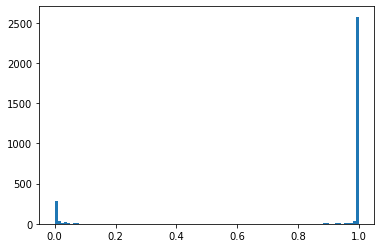

In [42]:
_ = plt.hist(m.corpus_res.similarity, bins = 100)

In [43]:
t1 = m.corpus_res.similarity
sum(t1 > 0.99) / len(t1), sum(t1 > 0.9) / len(t1), sum(t1 < 0.5) / len(t1)

(0.8282958199356913, 0.8562700964630225, 0.13408360128617364)

In [44]:
m.best_matches.shape

(5, 9)

In [45]:
m.best_matches.head(3)

,q_id,q_title,tags,accepted_answer_id,a_body,a_images_list,a_code_snippets,a_cleaned_body,similarity
1530,36066080,Optimize pendulum animation (javascript),javascriptanimationd3.jssvgplotly,36072487.0,"<p>I'm the author of <a href=""http://maurizzzi...",[],"[<code>width x height</code>, <code>[xMin, yMi...",I'm the author of function plot which is buil...,0.999997
2558,15141204,WPF C# DynamicDataDisplay - Changing the DateT...,c#wpfchartsdynamic-data-display,19841218.0,"<p>Curiously, I've happened to be trying to do...",[],"[<code>MayorDateTimeLabelProvider.cs</code>, <...","Curiously, I've happened to be trying to do t...",0.999996
2961,34930763,What is the logic behind d3.js nice() ticks,javascriptpythond3.jschartspycairo,34931208.0,"<p>D3 is open source, so you can <a href=""http...",[],[<code>domain[i0] = nice.floor(x0);\r\r\r\ndom...,"D3 is open source, so you can look up the imp...",0.999996


# list of user input questions

note, if running on just CPU, is way too slow even with only 600 records

In [24]:
question_list = [
    'Is there a way to visualize the distribution of my data?',
    'How do I show data on a map?',
    'How can I illustrate changes in my data over time?',
    'Is there a way to show a “heatmap” of my data?',
    'How can I present a picture of a network?',
    'How can I plot a comparison of two data sets?',
    'How can I create a chart without coding?',
    'When should I use a bar chart versus a pie chart?',
    'What is the easiest way to create a diagram of a network?',
    'I need help creating a visualization/diagram/presentation of my data',
    'When should I use a scatter plot?',
    'Data visualization tips',
    'How do I make a network diagram in d3?',
    'How do I plot 2 datasets?',
    'How can I animate a bar chart in Python?',
    'I know how to create a line chart with matplotlib, but how do I do it in R?',
    'What is the easiest way to create a heat map of the US?',
    'How can I animate a choropleth in Tableau?  In PowerBI?  In D3?'
]

def g1(question_list, m):
    res = []
    res_df = pd.DataFrame()
    for q in question_list:
        similar_que, similar_ans = m.get_similar_documents(query = q, num_results = 5)
        t1 = m.best_matches.copy()
        t1["user_input"] = q
        t2 = t1[[
            "user_input"
            , "similarity"
            , "q_id"
            , "q_title"
            , "tags"
            , "accepted_answer_id"
            , "a_body"
            , "a_cleaned_body"
        ]]
        res.append(t2)
    res_df = pd.concat(res)
    res_df.sort_values(["user_input", "similarity"], ascending=[True, False])
    return(res_df)

t1 = g1(question_list,m)

11/21/2019 09:20:33 - INFO - bert -   *** Example ***
11/21/2019 09:20:33 - INFO - bert -   tokens: [CLS] is there a way to visual ##ize the distribution of my data ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:20:33 - INFO - bert -   input_ids: 101 2003 2045 1037 2126 2000 5107 4697 1996 4353 1997 2026 2951 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:20:33 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/21/2019 09:20:33 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:20:33 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:20:33 - INFO - bert -   *** Example ***
11/21/2019 09:20:33 - INFO - bert -   tokens:

11/21/2019 09:20:57 - INFO - bert -   *** Example ***
11/21/2019 09:20:57 - INFO - bert -   tokens: [CLS] how do i show data on a map ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:20:57 - INFO - bert -   input_ids: 101 2129 2079 1045 2265 2951 2006 1037 4949 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:20:57 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

11/21/2019 09:20:57 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:20:57 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:20:57 - INFO - bert -   *** Example ***
11/21/2019 09:20:57 - INFO - bert -   tokens:

11/21/2019 09:21:20 - INFO - bert -   *** Example ***
11/21/2019 09:21:20 - INFO - bert -   tokens: [CLS] how can i illustrate changes in my data over time ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:21:20 - INFO - bert -   input_ids: 101 2129 2064 1045 19141 3431 1999 2026 2951 2058 2051 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:21:20 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/21/2019 09:21:20 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:21:20 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:21:20 - INFO - bert -   *** Example ***
11/21/2019 09:21:20 - INFO - bert -   tokens:

11/21/2019 09:21:44 - INFO - bert -   *** Example ***
11/21/2019 09:21:44 - INFO - bert -   tokens: [CLS] is there a way to show a “ heat ##ma ##p ” of my data ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:21:44 - INFO - bert -   input_ids: 101 2003 2045 1037 2126 2000 2265 1037 1523 3684 2863 2361 1524 1997 2026 2951 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:21:44 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/21/2019 09:21:44 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:21:44 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:21:44 - INFO - bert -   *** Example ***
11/21/2019 09:21:44 - INFO - bert -   tokens:

11/21/2019 09:22:08 - INFO - bert -   *** Example ***
11/21/2019 09:22:08 - INFO - bert -   tokens: [CLS] how can i present a picture of a network ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:22:08 - INFO - bert -   input_ids: 101 2129 2064 1045 2556 1037 3861 1997 1037 2897 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:22:08 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

11/21/2019 09:22:08 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:22:08 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:22:08 - INFO - bert -   *** Example ***
11/21/2019 09:22:08 - INFO - bert -   tokens:

11/21/2019 09:22:32 - INFO - bert -   *** Example ***
11/21/2019 09:22:32 - INFO - bert -   tokens: [CLS] how can i plot a comparison of two data sets ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:22:32 - INFO - bert -   input_ids: 101 2129 2064 1045 5436 1037 7831 1997 2048 2951 4520 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:22:32 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/21/2019 09:22:32 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:22:32 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:22:32 - INFO - bert -   *** Example ***
11/21/2019 09:22:32 - INFO - bert -   tokens:

11/21/2019 09:22:55 - INFO - bert -   *** Example ***
11/21/2019 09:22:55 - INFO - bert -   tokens: [CLS] how can i create a chart without coding ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:22:55 - INFO - bert -   input_ids: 101 2129 2064 1045 3443 1037 3673 2302 16861 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:22:55 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/21/2019 09:22:55 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:22:55 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:22:55 - INFO - bert -   *** Example ***
11/21/2019 09:22:55 - INFO - bert -   tokens:

11/21/2019 09:23:19 - INFO - bert -   *** Example ***
11/21/2019 09:23:19 - INFO - bert -   tokens: [CLS] when should i use a bar chart versus a pie chart ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:23:19 - INFO - bert -   input_ids: 101 2043 2323 1045 2224 1037 3347 3673 6431 1037 11345 3673 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:23:19 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/21/2019 09:23:19 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:23:19 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:23:19 - INFO - bert -   *** Example ***
11/21/2019 09:23:19 - INFO - bert -   tokens:

11/21/2019 09:23:43 - INFO - bert -   *** Example ***
11/21/2019 09:23:43 - INFO - bert -   tokens: [CLS] what is the easiest way to create a diagram of a network ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:23:43 - INFO - bert -   input_ids: 101 2054 2003 1996 25551 2126 2000 3443 1037 16403 1997 1037 2897 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:23:43 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/21/2019 09:23:43 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:23:43 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:23:43 - INFO - bert -   *** Example ***
11/21/2019 09:23:43 - INFO - bert -   tokens:

11/21/2019 09:24:07 - INFO - bert -   *** Example ***
11/21/2019 09:24:07 - INFO - bert -   tokens: [CLS] i need help creating a visual ##ization / diagram / presentation of my data [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:24:07 - INFO - bert -   input_ids: 101 1045 2342 2393 4526 1037 5107 3989 1013 16403 1013 8312 1997 2026 2951 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:24:07 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

11/21/2019 09:24:07 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:24:07 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:24:07 - INFO - bert -   *** Example ***
11/21/2019 09:24:07 - INFO - bert -   tokens:

11/21/2019 09:24:31 - INFO - bert -   *** Example ***
11/21/2019 09:24:31 - INFO - bert -   tokens: [CLS] when should i use a sc ##atter plot ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:24:31 - INFO - bert -   input_ids: 101 2043 2323 1045 2224 1037 8040 20097 5436 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:24:31 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/21/2019 09:24:31 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:24:31 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:24:31 - INFO - bert -   *** Example ***
11/21/2019 09:24:31 - INFO - bert -   tokens:

11/21/2019 09:24:54 - INFO - bert -   *** Example ***
11/21/2019 09:24:54 - INFO - bert -   tokens: [CLS] data visual ##ization tips [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:24:54 - INFO - bert -   input_ids: 101 2951 5107 3989 10247 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:24:54 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/21/2019 09:24:54 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:24:54 - INFO - bert -   segment_ids: 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:24:54 - INFO - bert -   *** Example ***
11/21/2019 09:24:54 - INFO - bert -   tokens:

11/21/2019 09:25:18 - INFO - bert -   *** Example ***
11/21/2019 09:25:18 - INFO - bert -   tokens: [CLS] how do i make a network diagram in d ##3 ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:25:18 - INFO - bert -   input_ids: 101 2129 2079 1045 2191 1037 2897 16403 1999 1040 2509 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:25:18 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

11/21/2019 09:25:18 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:25:18 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:25:18 - INFO - bert -   *** Example ***
11/21/2019 09:25:18 - INFO - bert -   tokens:

11/21/2019 09:25:41 - INFO - bert -   *** Example ***
11/21/2019 09:25:41 - INFO - bert -   tokens: [CLS] how do i plot 2 data ##set ##s ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:25:41 - INFO - bert -   input_ids: 101 2129 2079 1045 5436 1016 2951 13462 2015 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:25:41 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

11/21/2019 09:25:41 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:25:41 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:25:41 - INFO - bert -   *** Example ***
11/21/2019 09:25:41 - INFO - bert -   tokens:

11/21/2019 09:26:05 - INFO - bert -   *** Example ***
11/21/2019 09:26:05 - INFO - bert -   tokens: [CLS] how can i an ##imate a bar chart in python ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:26:05 - INFO - bert -   input_ids: 101 2129 2064 1045 2019 21499 1037 3347 3673 1999 18750 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:26:05 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/21/2019 09:26:05 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:26:05 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:26:05 - INFO - bert -   *** Example ***
11/21/2019 09:26:05 - INFO - bert -   tokens:

11/21/2019 09:26:29 - INFO - bert -   *** Example ***
11/21/2019 09:26:29 - INFO - bert -   tokens: [CLS] i know how to create a line chart with mat ##pl ##ot ##lib , but how do i do it in r ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:26:29 - INFO - bert -   input_ids: 101 1045 2113 2129 2000 3443 1037 2240 3673 2007 13523 24759 4140 29521 1010 2021 2129 2079 1045 2079 2009 1999 1054 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:26:29 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0

11/21/2019 09:26:29 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:26:29 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:26:29 - INFO - bert -   *** Example ***
11/21/2019 09:26:29 - INFO - bert -   tokens:

11/21/2019 09:26:53 - INFO - bert -   *** Example ***
11/21/2019 09:26:53 - INFO - bert -   tokens: [CLS] what is the easiest way to create a heat map of the us ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:26:53 - INFO - bert -   input_ids: 101 2054 2003 1996 25551 2126 2000 3443 1037 3684 4949 1997 1996 2149 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:26:53 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

11/21/2019 09:26:53 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:26:53 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:26:53 - INFO - bert -   *** Example ***
11/21/2019 09:26:53 - INFO - bert -   tokens:

11/21/2019 09:27:17 - INFO - bert -   *** Example ***
11/21/2019 09:27:17 - INFO - bert -   tokens: [CLS] how can i an ##imate a cho ##rop ##let ##h in table ##au ? in power ##bi ? in d ##3 ? [SEP] points in is zero width , so you need to set the width of dod ##ging : [SEP]
11/21/2019 09:27:17 - INFO - bert -   input_ids: 101 2129 2064 1045 2019 21499 1037 16480 18981 7485 2232 1999 2795 4887 1029 1999 2373 5638 1029 1999 1040 2509 1029 102 2685 1999 2003 5717 9381 1010 2061 2017 2342 2000 2275 1996 9381 1997 26489 4726 1024 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/21/2019 09:27:17 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0

11/21/2019 09:27:17 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:27:17 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
11/21/2019 09:27:17 - INFO - bert -   *** Example ***
11/21/2019 09:27:17 - INFO - bert -   tokens:

In [30]:
t1.head(10)

,user_input,similarity,q_id,q_title,tags,accepted_answer_id,a_body,a_cleaned_body
3,Is there a way to visualize the distribution o...,0.999996,7688275,save yaxis legends as a separate grob?,rggplot2,15642634.0,"<p>This question has been sitting long enough,...","This question has been sitting long enough, t..."
1432,Is there a way to visualize the distribution o...,0.999996,36205526,Tooltip bug with dynamic google charts,javascriptsvgdynamicchartstimeline,36206232.0,"<p>So I found the solution , </p>\r\r\r\n\r\r\...","So I found the solution , Every time you ""red..."
1870,Is there a way to visualize the distribution o...,0.999996,50689123,Making a solid contour using seaborn in Python,pythonplotseaborn,50689263.0,<p>You are referring to a <code>kdeplot</code>...,You are referring to a here. This usually nee...
1067,Is there a way to visualize the distribution o...,0.999995,15468622,Facebook search API without locale,facebookapifacebook-graph-apisearchlocale,15549177.0,<p>I don't think so. </p>\r\r\r\n\r\r\r\n<p>If...,I don't think so. If you try a different quer...
2534,Is there a way to visualize the distribution o...,0.999995,15053686,Networkx: Overlapping edges when visualizing M...,pythonpython-2.7matplotlibgraphviznetworkx,15069150.0,<p>Unfortunately not. It is technically poss...,Unfortunately not. It is technically possib...
1295,How do I show data on a map?,0.999996,56212612,Calling a hook (useMutation) inside an event h...,reactjsgraphqlreact-hooksmutation,56212940.0,"<blockquote>\r\r\r\n <p>So, how do I call a m...","So, how do I call a mutation inside an event ..."
2803,How do I show data on a map?,0.999995,1095419,Is there an API for openstreetmap?,apigeospatialopenstreetmap,16789444.0,<p>I've found a great API for reading Openstre...,I've found a great API for reading Openstreet...
2964,How do I show data on a map?,0.999995,34715002,How to validated geography polygon in SQL serv...,sql-server-2008validationpolygongeospatialgeog...,48818388.0,<p>This is working for me on SQL Server 2008. ...,This is working for me on SQL Server 2008. Af...
1432,How do I show data on a map?,0.999995,36205526,Tooltip bug with dynamic google charts,javascriptsvgdynamicchartstimeline,36206232.0,"<p>So I found the solution , </p>\r\r\r\n\r\r\...","So I found the solution , Every time you ""red..."
545,How do I show data on a map?,0.999995,2768762,Why should I use floats?,iphonequartz-graphics,2768945.0,"<p>If you draw <a href=""http://en.wikipedia.or...","If you draw anti-aliased geometry, you need f..."


In [29]:
p_out = "../data/processed/similar_yyq5c.tsv"
t1.to_csv(p_out, sep = "\t", index = False, encoding = "utf-8")

In [32]:
p_out = "../data/processed/similar_yyq5c.xlsx"
t1.to_excel(p_out)